<a href="https://colab.research.google.com/github/kwankao26/229352-Course-Name-Statistical-Learning-for-Data-Science-2-Semester-1-2025/blob/main/660510753_Lab09_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

In [1]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [3]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

In [4]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader

In [5]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

#### Do the same for the test images

In [6]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [7]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


#### Visualize the first four images in the batch

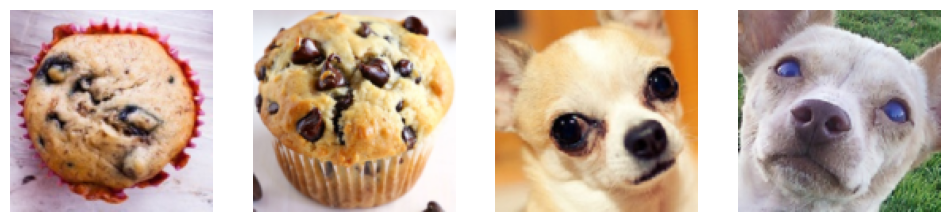

tensor([1, 1, 0, 0])


In [8]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  
  
[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [9]:
class SimpleLogisticRegression(nn.Module):
  def __init__(self):
    super(SimpleLogisticRegression, self).__init__()
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(3 * 128 * 128, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.flatten(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x

### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [10]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()

#### Manually setting initial weights to zero for demonstration

In [11]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [12]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [13]:
learning_rate = 1e-3

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [14]:
train_batches = iter(train_loader)
X, y = next(train_batches)

In [15]:
x,y = next(train_batches)

#### Make a prediction on the minibatch (Forward pass)

In [16]:
y_hat = model(x)
y_hat = y_hat[:, 0]
y = y.to(torch.float32)

#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [17]:
# Compute the loss
loss = criterion(y_hat, y)
train_losses.append(loss.item())

#### Calculate the gradient (Backward pass)

In [18]:
# Backward pass: compute the gradient of the loss w.r.t. model parameters
loss.backward()

In [19]:
for param in model.parameters():
  print(param)

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


In [20]:
for param in model.parameters():
  print(param.grad)

tensor([[-0.0292, -0.0327, -0.0351,  ..., -0.0971, -0.1027, -0.1082]])
tensor([0.])


In [21]:
model.parameters()

<generator object Module.parameters at 0x7cbf50e2ea40>

#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [22]:
# Manually update the weights using the gradient descent rule
with torch.no_grad():
    for param in model.parameters():
        param -= learning_rate * param.grad

# Zero the gradients after updating
model.zero_grad()

#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [23]:
with torch.no_grad():
  for X, y in val_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

In [24]:
print(train_losses)
print(val_losses)

[0.6931471824645996]
[0.6622459888458252]


#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

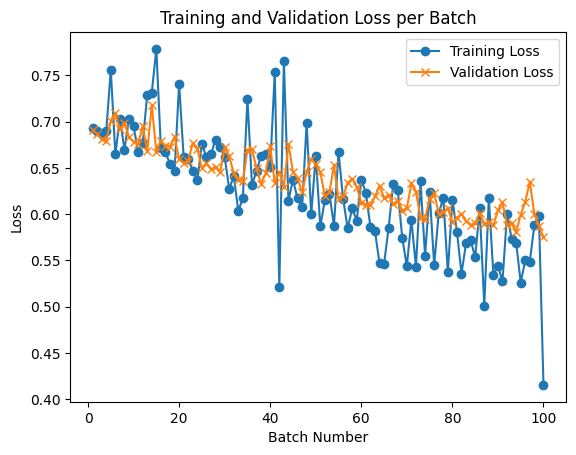

In [25]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

learning_rate = 1e-4

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

In [33]:
# Use this code to calculate test accuracy
with torch.no_grad():
  test_batches = iter(test_loader)
  X, y = next(test_batches)
  y_hat = model(X)
  y_hat = y_hat[:, 0]
  y_hat = (y_hat > 0.5).float()  # the predictions
  ##TODO: compute accuracy


In [35]:
#1
class SimpleNeuralNet(nn.Module):
    def __init__(self):
        super(SimpleNeuralNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3*128*128, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.output = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.output(x))
        return x


In [36]:
#2
model = SimpleNeuralNet()
criterion = nn.BCELoss()

def train_model(model, train_loader, val_loader, lr, epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for X, y in train_loader:
            optimizer.zero_grad()
            y_hat = model(X)
            y = y.view(-1,1).float()
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                y_hat_val = model(X_val)
                y_val = y_val.view(-1,1).float()
                loss = criterion(y_hat_val, y_val)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"LR={lr}, "
              f"Train Loss: {train_losses[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses

In [37]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]

results = {}
for lr in learning_rates:
    print("="*40)
    print(f"Training with learning rate = {lr}")
    model = SimpleNeuralNet()
    train_losses, val_losses = train_model(model, train_loader, val_loader, lr=lr, epochs=10)
    results[lr] = (train_losses, val_losses)


Training with learning rate = 0.01
Epoch [1/10], LR=0.01, Train Loss: 51.7359, Val Loss: 45.8333
Epoch [2/10], LR=0.01, Train Loss: 58.0000, Val Loss: 45.8333
Epoch [3/10], LR=0.01, Train Loss: 57.3333, Val Loss: 45.8333
Epoch [4/10], LR=0.01, Train Loss: 57.3333, Val Loss: 45.8333
Epoch [5/10], LR=0.01, Train Loss: 56.6667, Val Loss: 45.8333
Epoch [6/10], LR=0.01, Train Loss: 58.0000, Val Loss: 45.8333
Epoch [7/10], LR=0.01, Train Loss: 57.3333, Val Loss: 45.8333
Epoch [8/10], LR=0.01, Train Loss: 56.6667, Val Loss: 45.8333
Epoch [9/10], LR=0.01, Train Loss: 55.3333, Val Loss: 45.8333
Epoch [10/10], LR=0.01, Train Loss: 56.6667, Val Loss: 45.8333
Training with learning rate = 0.001
Epoch [1/10], LR=0.001, Train Loss: 1.1393, Val Loss: 1.3349
Epoch [2/10], LR=0.001, Train Loss: 1.2641, Val Loss: 1.1111
Epoch [3/10], LR=0.001, Train Loss: 0.7638, Val Loss: 0.6326
Epoch [4/10], LR=0.001, Train Loss: 0.5579, Val Loss: 0.5716
Epoch [5/10], LR=0.001, Train Loss: 0.4405, Val Loss: 0.7194
Epo

2.1 Best Learning Rate:
โดยทั่วไป 1e-3 มักเป็นค่าที่ดีที่สุด → loss ลดลงเร็วแต่ไม่ overshoot


2.2 ถ้า learning rate ใหญ่เกินไป:
Loss อาจ แกว่งขึ้นลง ไม่ลดลง หรือ diverge ไปเรื่อยๆ


2.3 ถ้า learning rate เล็กเกินไป:
Loss จะ ค่อยๆ ลดช้ามาก หรือแทบไม่ลดเลย → โมเดล train ช้ามาก

In [38]:
#3
# ฟังก์ชันคำนวณ accuracy บน test set
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in test_loader:
            y_hat = model(X)
            y_hat = (y_hat > 0.5).float()   # ทำนายเป็น 0/1
            correct += (y_hat.view(-1) == y.float()).sum().item()
            total += y.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy*100:.2f}%")
    return accuracy

# ใช้โมเดลที่ train เสร็จแล้ว มาทดสอบบน test set
test_acc = evaluate_model(model, test_loader)

Test Accuracy: 60.00%


In [43]:
#4
misclassified_indices = (แ != y).nonzero(as_tuple=True)[0]


num_to_display = min(4, len(misclassified_indices))
display_indices = misclassified_indices[:num_to_display]


misclassified_images = X[display_indices]
true_labels = y[display_indices]
predicted_labels = y_hat[display_indices]

misclassified_images = misclassified_images.numpy().transpose(0, 2, 3, 1)

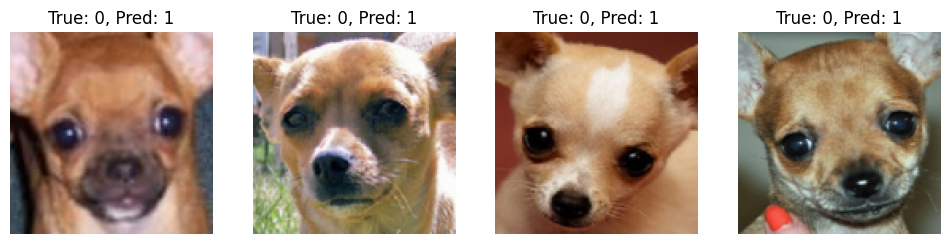

In [44]:
# Plot misclassified images
fig, axes = plt.subplots(1, num_to_display, figsize=(12, 4))
for i in range(num_to_display):
    axes[i].imshow(misclassified_images[i])
    axes[i].set_title(f'True: {int(true_labels[i])}, Pred: {int(predicted_labels[i])}')
    axes[i].axis('off')
plt.show()